### Neural network from scratch.

Based on YSDA Deep Learning course materials.

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

We will implement most common layers using `numpy` for matrix operations. In file `modules.py` are presented the abstract classes for layer, criterion and sequential model class.

The architecture, naming and API are inspired py PyTorch implementation, which will be used in this course further. 

Please, __do not__ change the classes/functions signatures.

#### Some comments
Original `numpy` operation are more preferable than overloaded ones (`+`, `*`, `-`, etc. vs `np.add`, `np.multiply`, `np.substract`). They show more expectable memory usage and seem unified with tensor frameworks.

*Example:*

```
a = np.zeros_like(arr1)

a = arr1 + arr2 #  bad, we reallocate memory for the result of + operation

a = np.zeros_like(arr1)

np.add(arr1, arr2, out=a) #  good, we use same allocated memory, no need to call gc
```

In [6]:
from modules import Module, Sequential, Criterion

### Impelementing main layers

Before we begin: a [great playground](https://playground.tensorflow.org) to look at.

Try to implement main layers in numpy. Today we stop only on most common ones.

Good read on [Vector, Matrix and Tensor derivatives](http://cs231n.stanford.edu/vecDerivs.pdf)

In [113]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D _input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)

        self.W = np.random.uniform(-stdv, stdv, size = (n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, _input):
        # Your code goes here. ################################################
        print(_input)
        print(self.W)
        print(self.b)
        self.output = np.matmul(_input, self.W) + self.b[None,:]
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.matmul(gradOutput, self.W.T)
        return self.gradInput
    
    def accGradParameters(self, _input, gradOutput):
        # Your code goes here. ################################################
        # self.gradW = ... ; self.gradb = ...
        self.gradW += np.matmul(_input.T, gradOutput)
        self.gradb += np.sum(gradOutput, axis=0)
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [8]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        self.output = np.subtract(_input, _input.max(axis=1, keepdims=True))
        
        self.output = np.exp(self.output)
        self.output = self.output / np.sum(self.output, axis=1, keepdims=True)
        
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
          ################################################
        # First we create for each example feature vector, it's outer product with itself
        # ( p1^2  p1*p2  p1*p3 .... )
        # ( p2*p1 p2^2   p2*p3 .... )
        # ( ...                     )
        local_repr1 = np.einsum('bi,bj->bij', self.output, self.output)
        # your code here 
        # Second we need to create an (n_feats, n_feats) identity of the feature vector
        # ( p1  0  0  ...  )
        # ( 0   p2 0  ...  )
        # ( ...            )
        # your code here 
        local_repr2 = np.einsum('bi,ij->bij', self.output, np.eye(_input.shape[1], _input.shape[1]))
        # Then we need to subtract the first tensor from the second
        # ( p1 - p1^2   -p1*p2   -p1*p3  ... )
        # ( -p1*p2     p2 - p2^2   -p2*p3 ...)
        # ( ...                              )
        # your code here 
        local_repr = local_repr2 - local_repr1
        self.gradInput = np.einsum('bij,bi->bj', local_repr, gradOutput)
        ################################################
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

In [90]:
class LogSoftMax(Module):
    EPS = 1e-15
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, _input):
        # start with normalization for numerical stability
        self.output = np.subtract(_input, _input.max(axis=1, keepdims=True))
        self.output = np.exp(self.output)
        self.output = self.output / np.sum(self.output, axis=1, keepdims=True)
        clipped_input = np.clip(self.output, self.EPS,1 - self.EPS)
        self.output = np.log(clipped_input)
        # Your code goes here. ################################################

        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################
        local_repr2 = np.einsum('bi,ij->bij', self.output, np.eye(_input.shape[1], _input.shape[1]))
        local_repr = np.eye(_input.shape[1], _input.shape[1]) - local_repr2
        self.gradInput = np.einsum('bij,bi->bj', local_repr, gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

In [10]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, _input):
        self.output = np.maximum(_input, 0)
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.multiply(gradOutput , _input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

In [16]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, _input):
        # Your code goes here. ################################################

        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        # Your code goes here. ################################################

        return self.slope * (1 - mask) * gradOutput + mask * gradOutput
    
    def __repr__(self):
        return "LeakyReLU"

In [13]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target):   
        ################################################
        # Use clipping trick to avoid numerical errors
        # your code here 
        ################################################
        clipped_input = np.clip(input, self.EPS,1 - self.EPS)
        self.output = -np.sum(target * np.log(clipped_input))  / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        ################################################
        # Use clipping trick to avoid numerical errors
        # your code here 
        ################################################
        clipped_input = np.clip(input, self.EPS,1 - self.EPS)
        self.gradInput = -(target/clipped_input) / input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

In [ ]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, _input, target): 
        # Your code goes here. ################################################
        self.output = -np.sum(target * _input)  / _input.shape[0]
        return self.output

    def updateGradInput(self, _input, target):
        # Your code goes here. ################################################
        self.gradInput = -(target/np.exp(_input) / _input.shape[0])
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

In [27]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1     

### Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

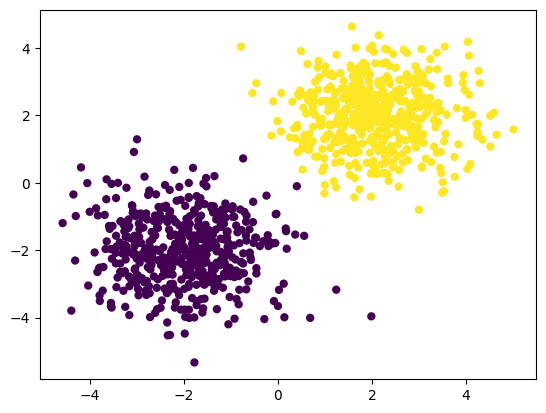

In [16]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [91]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

#net = Sequential()
#net.add(Linear(2, 4))
#net.add(ReLU())
#net.add(Linear(4, 2))
#net.add(LogSoftMax())

#print(net)

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [92]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [93]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [108]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

[[ 2.36997492  0.88693444]
 [ 1.9087669   2.51691075]
 [ 2.85640926  2.35957698]
 [ 0.98893252 -0.31903111]
 [ 3.05416938  3.96393397]
 [ 0.88728903  1.82280212]
 [ 3.10235808  1.18793266]
 [ 3.56703458  1.44985713]
 [-2.41089282 -3.14056752]
 [ 1.65002788  4.00725864]
 [ 0.66223098  0.97818058]
 [ 0.80047753  1.99923162]
 [-0.09903892  2.41657267]
 [-3.36413527 -1.77046029]
 [ 3.97304501  2.75056311]
 [ 2.25426029  1.28554231]
 [-1.70423709 -1.29122719]
 [-1.5024425  -2.95602553]
 [ 2.35443541  1.85734049]
 [-1.20678944 -1.31077917]
 [ 0.90324572  2.39898208]
 [-1.11810291 -2.77355413]
 [ 4.13165638  2.01374767]
 [-1.50545672 -1.5456415 ]
 [ 2.27611788  0.77115315]
 [ 2.38867931  2.31883752]
 [-2.17459608 -3.54953287]
 [-1.89708406 -0.00602168]
 [ 1.25333874  1.21034972]
 [ 1.74578187  2.05895905]
 [ 2.44836625  0.46063918]
 [ 0.91745321  1.6885836 ]
 [-2.80583257 -1.94946603]
 [-3.43658714 -3.09726374]
 [-3.17766006 -1.08919752]
 [ 2.26724072  2.55669235]
 [-1.84250354 -2.14214964]
 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 784 is different from 2)

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [32]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [61]:
import mnist
from sklearn.preprocessing import OneHotEncoder

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()  # your dataset
print(X_train.shape)
X_train = np.array([np.array(q.flatten()) for q in X_train])
print(X_train.shape)
X_val = np.array([np.array(q.flatten()) for q in X_val])
X_test = np.array([np.array(q.flatten()) for q in X_test])

encoder = OneHotEncoder(categories='auto', sparse=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))

(50000, 28, 28)
(50000, 784)


In [75]:
X_train, X_val, X_test = list(map(lambda x: x.reshape((x.shape[0], -1)), [X_train, X_val, X_test]))

In [63]:
X_train.shape

(50000, 784)

In [115]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 128 -> 784
ReLU
Linear 10 -> 128
LogSoftMax



In [110]:
# Iptimizer params
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5}
optimizer_state = {}

# Looping params
n_epoch = 1
batch_size = 128

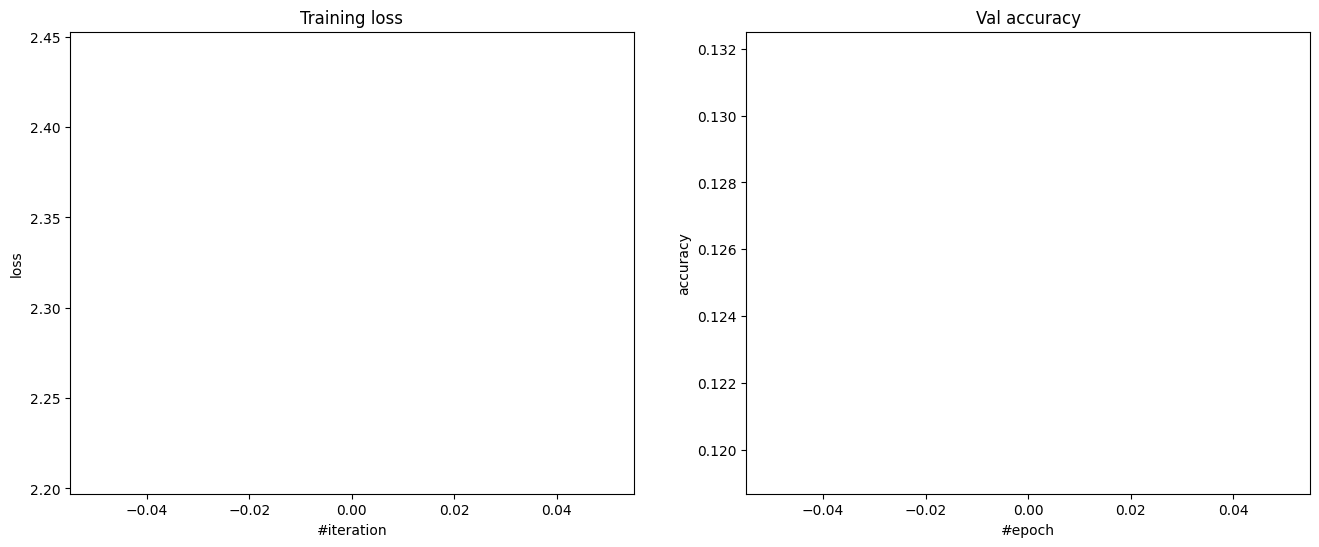

Current loss: 2.324957


In [116]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []

for i in range(n_epoch):
    net.train()
    for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

        break
    
    net.evaluate()
    accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)    
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    
    plt.subplot(1, 2, 2)
    plt.title("Val accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(accuracy_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)   